In [72]:
import pickle
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'seaborn'

### Creating helper functions to run the experiment

In [61]:
# Normalizing the sorted_MX and sorted_MY
def normalize(X):
	# length normalization
	x = X/np.linalg.norm(X, axis = 1).reshape(-1, 1)
	# mean centering each dimension
	x = x - x.mean(axis = 0)
	# length normalizing the mean centered data
	x = x/np.linalg.norm(x, axis = 1).reshape(-1, 1)
	return x

# computing sqaure root of similiarity matrices for both the embedding matrices using svd
def sim_matrix(X, size):
	u, s, _ = np.linalg.svd(X[:size], full_matrices = False)
	return np.dot(u*s, u.T)

def distance_matrix(X1, Y1):
	norm_X1 = np.linalg.norm(X1, axis = 1).reshape(-1,1)**2
	b = np.ones((norm_X1.shape[0], norm_X1.shape[1]+1))
	b[:, :-1] = norm_X1
	norm_X1 = b

	norm_Y1 = np.linalg.norm(Y1, axis = 1).reshape(-1,1)**2
	b = np.ones((norm_Y1.shape[0], norm_Y1.shape[1]+1))
	b[:, 1:] = norm_Y1
	norm_Y1 = b

	dot_p = -2*np.matmul(X1, Y1.T)
	d_matrix = np.matmul(norm_X1, norm_Y1.T) + dot_p
	return d_matrix

def create_idx2word_dict(vocab):
	idx2word = {}
	for i in vocab:
		idx2word[vocab[i]] = i

	return idx2word

### Loading hindi english vocabulary and embedding matrices

In [62]:
hindi_embedding_matrix = pickle.load(open("./hindi_embedding_matrix.pkl", "rb"))
english_embedding_matrix = pickle.load(open("./english_embedding_matrix.pkl", "rb"))
hindi_vocab = pickle.load(open("./hindi_vocab.pkl", "rb"))
english_vocab = pickle.load(open("./english_vocab.pkl", "rb"))

hindi_idx2word = create_idx2word_dict(hindi_vocab)
english_idx2word = create_idx2word_dict(english_vocab)

X = hindi_embedding_matrix
Y = english_embedding_matrix
D = np.zeros((X.shape[0], Y.shape[0]))

SIM_SIZE = min(X.shape[0], Y.shape[0])

### Step 1: Normalize Embeddings

In [63]:
# normalizing the embeddings
X = normalize(X)
Y = normalize(Y)

### Step 2: Unsupervised Initialization

In [64]:
# similarity matrices
MX = sim_matrix(X, SIM_SIZE)
MY = sim_matrix(Y, SIM_SIZE)

# sorting MX and MY along the rows in order to align them along the j dimension
sorted_MX = np.sort(MX, axis = 1)
sorted_MY = np.sort(MY, axis = 1)

# normalized embeddings for extracting alignment across vocabulary(ith dimension)
X1 = normalize(sorted_MX)
Y1 = normalize(sorted_MY)

/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/zubair/anaconda3/envs/NLP/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


### Step 3: Self Learning

In [70]:
# constructing initial solution for the iterative algorithm
d_matrix = distance_matrix(X1, Y1)
nearest_neighbors = d_matrix.argmin(axis = 1)
D[range(nearest_neighbors.shape[0]), nearest_neighbors] = 1

# training loop
num_iter = 10
for i in range(num_iter):
	#computing the optimal orthogonal matrix which maximizes the current dict D
	u, s, vh = np.linalg.svd(np.dot(X.T, np.dot(D, Y)))
	WX = u
	WY = vh

	#computing the optimal dictionary using the similarity matrix of the mapped embeddings
	D = np.zeros((X.shape[0], Y.shape[0]))
	d_matrix = distance_matrix(np.dot(X, WX), np.dot(Y, WY))
	nearest_neighbors = d_matrix.argmin(axis = 1)
	D[range(nearest_neighbors.shape[0]), nearest_neighbors] = 1

# testing
d_matrix = distance_matrix(np.dot(X, WX), np.dot(Y, WY))
nearest_neighbors = d_matrix.argmin(axis = 1)

for i in range(10):
    print(hindi_idx2word[i], english_idx2word[nearest_neighbors[i]])

In [69]:
D

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
word_pairs = [
    ['और', 'and'],
    ['उसकी', 'his'],
    ['उसकी', 'and']
#     ['यहूद', 'were'],
#     ['लेख', 'article'],
]

## Visualisation

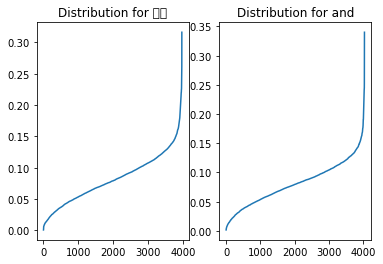

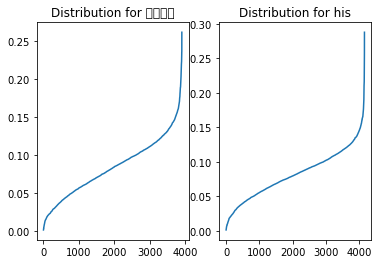

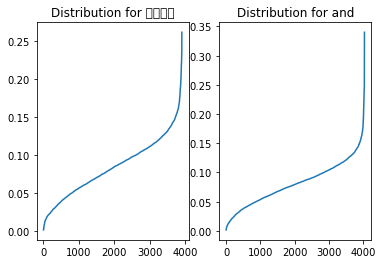

In [68]:
for hi, en in word_pairs:
    hi_index = hindi_vocab[hi]
    en_index = english_vocab[en]
    
    hi_mean = sorted_MX[hi_index]
    en_mean = sorted_MY[en_index]
    
    plt.subplot(1,2,1)
    plt.title('Distribution for {0}'.format(hi))
    plt.plot(hi_mean)
    
    plt.subplot(1,2,2)
    plt.title('Distribution for {0}'.format(en))
    plt.plot(en_mean)
    
    plt.show()

In [29]:
transform_x = np.dot(X, WX)

In [33]:
hindi_idx2word[0]

'कोई'

In [35]:
print(X[0], transform_x[0])

[ 4.63053510e-02 -5.96961677e-02 -6.28718212e-02  4.41755392e-02
 -7.42579475e-02 -2.38388386e-02  4.69245277e-02  3.98744643e-02
 -6.82294443e-02 -1.40330732e-01  9.62985381e-02  7.01462571e-03
  8.07450190e-02 -1.17835335e-01  1.03698783e-01  8.84633213e-02
  1.46564990e-01  3.16890764e-05 -2.18667954e-01 -3.74034904e-02
  7.28726238e-02 -4.61323895e-02 -3.34828421e-02  1.76913273e-02
  8.25952888e-02  2.82757580e-02 -6.27151653e-02  9.91098732e-02
  1.42784053e-02  4.29493561e-02  6.27091751e-02 -2.88868230e-02
 -1.49040958e-02  4.73422520e-02 -8.41436163e-02 -2.93554738e-02
  1.55689970e-01 -9.37642157e-02 -7.35794753e-02 -1.55795485e-01
  6.73232451e-02 -5.97964264e-02 -7.17872530e-02  4.13488187e-02
  1.14327326e-01 -1.11538529e-01  2.30286881e-01  2.01665685e-02
 -1.57701429e-02 -1.71978295e-01  6.90863505e-02  2.33648233e-02
  7.73479715e-02 -9.14351568e-02 -7.95619190e-03 -1.12567239e-01
  1.07732207e-01 -1.39830932e-01  4.06571552e-02 -1.10408552e-02
 -7.38289207e-02  1.29505

83

In [27]:
np.mean(np.dot(X, WX), axis=0)

array([ 2.53268141e-02, -2.46875027e-02, -1.03053308e-02, -4.33102300e-03,
        2.84499046e-02, -1.47303371e-03, -8.59754233e-03, -1.34157054e-03,
       -2.45689401e-03,  1.27837378e-02,  3.37582172e-03,  1.80821938e-03,
        7.11572564e-03,  5.96658916e-03, -3.31268736e-03, -6.43079492e-03,
       -8.48037235e-04, -4.04037995e-03, -7.79543189e-04,  8.12883330e-04,
       -3.14745946e-03, -2.87734681e-05, -1.30360468e-03, -8.34367772e-04,
       -2.48064667e-04, -1.94386284e-03,  1.74836561e-03, -8.02949885e-04,
        3.80942541e-06,  2.00102257e-04,  1.13167778e-04,  5.86584895e-04,
        9.52285611e-04, -4.02565857e-04, -2.95233454e-04, -3.40593526e-04,
       -4.33428123e-04,  1.06733188e-04,  1.49147800e-04,  1.42887034e-05,
        2.21826520e-04, -4.03443811e-04,  1.14144603e-04,  7.58027649e-05,
        3.23612934e-04, -6.43806637e-05, -5.38926466e-05,  1.55478981e-04,
        3.04452458e-04, -2.78246508e-05,  8.41120436e-05, -1.43804913e-04,
        1.03614716e-04, -

In [28]:
np.mean(np.dot(Y, WY), axis=0)

array([ 9.53943750e-04, -1.78154961e-03, -2.47934412e-03,  9.43307675e-04,
        8.46739705e-04,  1.24643223e-04,  5.35373616e-04,  3.54508953e-03,
       -3.78626546e-03,  4.09086665e-03, -2.85445494e-03,  2.23717580e-03,
        2.49460289e-04,  2.33167034e-03,  4.66165179e-03, -5.12875143e-03,
        1.63629246e-03,  1.78003879e-03,  2.49442395e-03, -1.55153884e-03,
        3.72083531e-03, -1.85375931e-03,  3.03247928e-03, -1.60091444e-03,
       -1.80480401e-03,  2.92442295e-03,  5.16664180e-04, -1.49394487e-04,
        7.84762632e-04,  1.26522839e-03, -1.47206336e-03, -5.47422467e-03,
        1.34815662e-03,  2.40001718e-03,  3.44778956e-03, -2.83883543e-03,
       -1.67438190e-03, -1.79063445e-03, -1.59432928e-03, -2.22953886e-03,
       -2.52675665e-05,  1.47433590e-04,  8.60458718e-03, -2.60803150e-03,
        1.61873961e-03, -2.32969714e-03,  6.36808609e-04,  6.37818066e-04,
        4.21552169e-04, -5.91316448e-05,  4.33058646e-03, -1.46910926e-03,
       -2.18462176e-03, -

In [ ]:
for en, hi in pairs:
    

कोई fanfare
भी play
बीमारी plate
होने nut
पर windows
नियमित parks
चेकअप settlement
कराएँ count
, names
लापरवाही Joy
